In [340]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [341]:
stock_relation = pd.read_csv("../dataset/news/relation_all.csv")
stock_relation['time'] = pd.to_datetime(stock_relation['time'])
stock_relation

,ticker,sentiment,sentiment_reasoning,news_id,source_ticker,time
0,NFLX,positive,The article indicates that significant investo...,d913f8609f0266a3934c767e3e08b5cb3a5b907373cf4c...,NFLX,2024-07-02 17:46:38
1,AMZN,positive,AWS is mentioned as one of the biggest names i...,8acd1c36c41725f571ef8611bcecdb9223800381a2543b...,MSFT,2024-07-02 17:46:57
2,MSFT,positive,Microsoft is mentioned as one of the prominent...,8acd1c36c41725f571ef8611bcecdb9223800381a2543b...,GOOGL,2024-07-02 17:46:57
3,GOOG,positive,Google is also mentioned as one of the promine...,8acd1c36c41725f571ef8611bcecdb9223800381a2543b...,GOOGL,2024-07-02 17:46:57
4,GOOGL,positive,Google is also mentioned as one of the promine...,8acd1c36c41725f571ef8611bcecdb9223800381a2543b...,GOOGL,2024-07-02 17:46:57
...,...,...,...,...,...,...
25522,META,neutral,The article mentions Meta Platforms' developme...,1d9a233266513e7565c8aa26700bc8a7fad1acb0eb8f8f...,NVDA,2024-10-31 04:26:28
25523,AMD,positive,The article highlights AMD CEO Lisa Su's optim...,1d9a233266513e7565c8aa26700bc8a7fad1acb0eb8f8f...,NVDA,2024-10-31 04:26:28
25524,NVDA,neutral,The article acknowledges NVIDIA as a major com...,1d9a233266513e7565c8aa26700bc8a7fad1acb0eb8f8f...,META,2024-10-31 04:26:28
25525,META,neutral,The article mentions Meta Platforms' developme...,1d9a233266513e7565c8aa26700bc8a7fad1acb0eb8f8f...,META,2024-10-31 04:26:28


In [342]:
stock_relation['sentiment'].value_counts()

sentiment
positive    15321
neutral      7369
negative     2684
bearish        74
hold           42
bullish        32
mixed           5
Name: count, dtype: int64

In [343]:
ticker = 'AMZN'

In [344]:
stock_price = pd.read_csv(f"../dataset/stocks/{ticker}.csv")
stock_price['time'] = pd.to_datetime(stock_price['time'])
stock_price['trade_date'] = stock_price['time'].dt.date
stock_price['delta'] = stock_price['close'].diff()
stock_price['prv_close'] = stock_price['close'].shift(periods=1, fill_value=None)
stock_price

,volumn,vwap,open,close,high,low,time,num_trades,trade_date,delta,prv_close
0,99248920.0,102.2496,103.560,102.44,104.8700,100.740,2022-10-31 04:00:00,755820,2022-10-31,NaN,NaN
1,153370022.0,98.2156,103.990,96.79,104.5800,96.060,2022-11-01 04:00:00,1356112,2022-11-01,-5.65,102.44
2,135730798.0,94.8311,97.315,92.12,97.7400,92.010,2022-11-02 04:00:00,1199947,2022-11-02,-4.67,96.79
3,136651803.0,90.3820,92.470,89.30,93.5000,89.020,2022-11-03 04:00:00,1217237,2022-11-03,-2.82,92.12
4,128579836.0,90.1098,91.490,90.98,92.4400,88.040,2022-11-04 04:00:00,1000081,2022-11-04,1.68,89.30
...,...,...,...,...,...,...,...,...,...,...,...
497,31410489.0,185.7016,188.850,184.71,189.1600,183.690,2024-10-23 04:00:00,402016,2024-10-23,-4.99,189.70
498,20385701.0,186.1250,185.250,186.38,187.1100,183.860,2024-10-24 04:00:00,300389,2024-10-24,1.67,184.71
499,27815175.0,188.7589,187.850,187.83,190.4500,187.530,2024-10-25 04:00:00,357467,2024-10-25,1.45,186.38
500,23009842.0,189.0699,189.565,188.39,190.2100,188.210,2024-10-28 04:00:00,330670,2024-10-28,0.56,187.83


In [345]:
def sentiment_transform(label):
    def func(series):
        return series.isin(label).sum() / series.count()
    return func

In [346]:
def sentiment_score(threshold, gt):
    def func(series):
        if gt:
            return series[series >= threshold].mean()
        else:
            return series[series <= threshold].mean()
    return func

In [347]:
relation_t = stock_relation[stock_relation['ticker'] == ticker]
relation_t['trade_date'] = (relation_t['time'] + pd.to_timedelta(0, unit='h')).dt.date
relation_t['same_source'] = (relation_t['source_ticker'] == relation_t['ticker']).astype(int)

relation_t['direct_sentiment'] = relation_t['sentiment']
relation_t.loc[relation_t['same_source'] == 0, 'direct_sentiment'] = 'None'


/var/folders/pj/znl5r0ln0hv_g1yjdthtr3f40000gn/T/ipykernel_1234/2764697557.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relation_t['trade_date'] = (relation_t['time'] + pd.to_timedelta(0, unit='h')).dt.date
/var/folders/pj/znl5r0ln0hv_g1yjdthtr3f40000gn/T/ipykernel_1234/2764697557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relation_t['same_source'] = (relation_t['source_ticker'] == relation_t['ticker']).astype(int)
/var/folders/pj/znl5r0ln0hv_g1yjdthtr3f40000gn/T/ipykernel_1234/2764697557.py

In [348]:
relation_t['news_id'].value_counts().describe()

count    764.000000
mean       2.401832
std        1.693267
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        8.000000
Name: count, dtype: float64

<Axes: xlabel='time'>

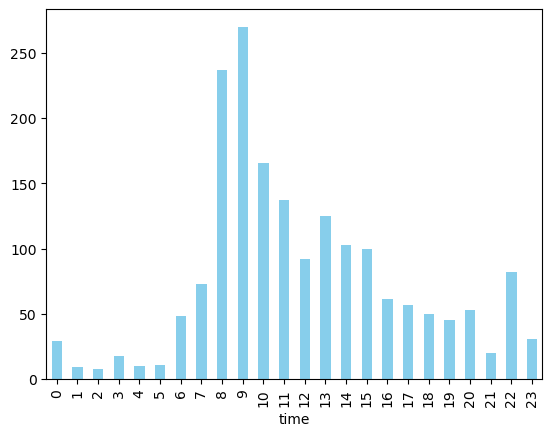

In [349]:
stock_date = relation_t['time'].dt.hour.value_counts().sort_index()
stock_date.plot(kind='bar', color='skyblue')

In [350]:
relation_gp = relation_t.groupby('trade_date').agg({
    'sentiment': [sentiment_transform(['positive', 'bullish']), sentiment_transform(['negative', 'bearish'])],
    'direct_sentiment': [sentiment_transform(['positive', 'bullish']), sentiment_transform(['negative', 'bearish'])],
}).fillna(0.0).reset_index()
relation_gp.columns = ['trade_date', 'positive', 'negative', 'dir_positive', 'dir_negative']

stock_comb = pd.merge(relation_gp, stock_price[['trade_date', 'prv_close', 'delta']], how='inner', on='trade_date')
stock_comb

,trade_date,positive,negative,dir_positive,dir_negative,prv_close,delta
0,2024-07-02,1.000000,0.000000,0.357143,0.000000,197.20,2.80
1,2024-07-03,0.631579,0.070175,0.263158,0.052632,200.00,-2.41
2,2024-07-05,0.654545,0.072727,0.200000,0.054545,197.59,2.41
3,2024-07-08,0.783784,0.189189,0.297297,0.027027,200.00,-0.71
4,2024-07-09,0.920000,0.080000,0.360000,0.080000,199.29,0.05
...,...,...,...,...,...,...,...
78,2024-10-23,0.750000,0.125000,0.625000,0.125000,189.70,-4.99
79,2024-10-24,0.750000,0.250000,0.500000,0.250000,184.71,1.67
80,2024-10-25,1.000000,0.000000,0.352941,0.000000,186.38,1.45
81,2024-10-28,1.000000,0.000000,0.300000,0.000000,187.83,0.56


In [351]:
stock_comb_t = stock_comb[stock_comb['negative'] > 0]
(stock_comb['dir_negative'] > 0).sum(), len(stock_comb_t), len(stock_comb)

(27, 27, 83)

In [352]:
def test_relevance(cols):
    X, y = stock_comb_t[cols], stock_comb_t['delta']
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, r2, model.coef_

In [353]:
test_relevance(['dir_negative', 'prv_close'])

(16.49561167745591, 0.021353721713282092, array([11.18193152,  0.0455343 ]))

In [354]:
test_relevance(['negative', 'prv_close'])

(16.524712859529497,
 0.019627216259168745,
 array([-4.58178363e+00, -2.02481823e-03]))

In [355]:
test_relevance(['dir_negative', 'negative', 'prv_close'])

(15.681249548928442,
 0.06966793290135542,
 array([ 2.28827687e+01, -9.74041393e+00, -3.63137598e-03]))

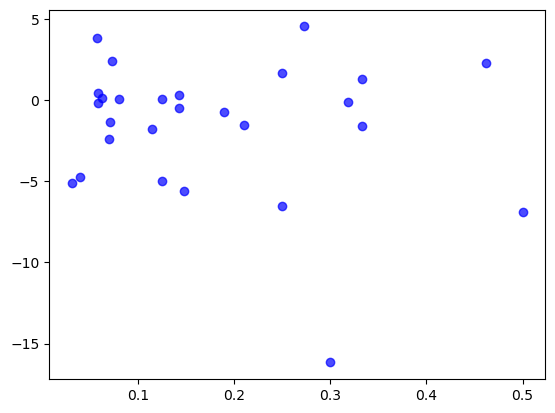

In [356]:
import matplotlib.pyplot as plt

plt.scatter(stock_comb_t['negative'], stock_comb_t['delta'], color='blue', alpha=0.7)